# Исследование рынка видеоигр и выявление определяющих успешность игры закономерностей

Для интернет-магазина, который продаёт по всему миру компьютерные игры, необходимо проанализировать данные из открытых источников о продажах игр, оценках пользователей и экспертов, жанрах и платформах, выявить определяющие успешность игры закономерности. 

Результаты исследования будут учтены при выборе интернет-магазином потенциально популярного продукта и планировании рекламных кампаний.

Необходимо:
- провести обработку данных, исследовательский анализ;
- составить портрет пользователей различных регионов;
- проверить гипотезы о равенстве пользовательских рейтингов в части платформ и жанров игр. 

### Описание данных

`Name` — название игры

`Platform` — платформа

`Year_of_Release` — год выпуска

`Genre` — жанр игры

`NA_sales` — продажи в Северной Америке (миллионы проданных копий)

`EU_sales` — продажи в Европе (миллионы проданных копий)

`JP_sales` — продажи в Японии (миллионы проданных копий)

`Other_sales` — продажи в других странах (миллионы проданных копий)

`Critic_Score` — оценка критиков (максимум 100)

`User_Score` — оценка пользователей (максимум 10)

`Rating` — возрастной рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

Данные за 2016 год могут быть неполными.

## Изучение общей информации из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display
from scipy import stats as st
from datetime import datetime as dt
import warnings

In [2]:
warnings.simplefilter('ignore')

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv') #запишем данные в переменную

In [4]:
data.info() #получим информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.head(10) #визуально оценим содержащиеся в таблице данные

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [6]:
data.isna().mean()[data.isna().mean() != 0] #определим наличие и долю пропусков

Name               0.000120
Year_of_Release    0.016093
Genre              0.000120
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

In [7]:
data.duplicated().sum() #определим наличие и общую сумму дубликатов

0

### Вывод

При изучении названия столбцов видно, что в дальнейшем их необходимо будет привести к нижнему регистру для удобства работы.

При изучении данных были выявлены пропущенные значения в названии игр, столбцах года выпуска, жанра, рейтингов критиков и пользователей, а также в возрастной рейтинге. Больше всего доля пропусков в данных по рейтингам (до половины), малая доля пропусков в данных названия игры, года выхода и жанра.

Дубликатов обнаружено не было.

## Подготовка данных

Приведем названия столбцов к нижнему регистру для упрощения работы с таблицей

In [8]:
data.columns = data.columns.str.lower()

In [9]:
data.columns #проверим названия столбцов после замены

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Продажи для всех регионов переведем из миллионов в тысячи, чтобы затем преобразовать в тип int - это возможно, потому что пропущенные значения в продажах отсутствуют. Данные типа int будут обрабатываться гораздо быстрее, чем float, а смысл данных и распределение не поменяются.

In [10]:
data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']] = (
    data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']] * 1000 #переводим миллионы в тысячи
).astype('int') #преобразование в тип int

In [11]:
data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].info() #проверяем успешность замены типа

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 4 columns):
na_sales       16715 non-null int64
eu_sales       16715 non-null int64
jp_sales       16715 non-null int64
other_sales    16715 non-null int64
dtypes: int64(4)
memory usage: 522.5 KB


При изучении данных было выявлено, что значения столбца оценки пользователей имеют тип данных object. Рассмотрим эти значения подробнее.

In [12]:
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Как видно, кроме пропущенные значений, в столбце user_score есть строкове значение tbd. Рассмотрим строки с таким значением для пользовательского рейтинга:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null int64
eu_sales           16715 non-null int64
jp_sales           16715 non-null int64
other_sales        16715 non-null int64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 1.4+ MB


In [14]:
data.query('user_score == "tbd"').head(5) #данные разнородны

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3450,2590,0,660,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2080,1350,0,540,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1510,1030,0,270,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1650,570,0,200,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2150,180,0,70,73.0,tbd,E


Согласно кебриджскому словарю:

TBD 

(also tbd) 

written abbreviation for to be decided or to be determined: used when something has not yet been decided or is not yet known

Таким образом, мы не можем заменить tbd на какое-либо значение - tbd означает, что значение пользовательских оценок ещё не определено. 

Чтобы иметь возможность работать со столбцом user_score, заменим строки tbd на пропуски - тогда значения столбца примут тип float.

In [15]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan #замена на NaN

In [16]:
data['user_score'] = data['user_score'].astype('float') #преобразуем тип в числовой float

In [17]:
data['user_score'].sort_values().unique() #проверим, какие значения теперь содержит user_score, тип все еще object

array([0. , 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5,
       1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
       2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1,
       4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4,
       5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7,
       6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ,
       8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3,
       9.4, 9.5, 9.6, 9.7, nan])

Теперь все значения укладываются в помежуток от 0 до 10. 

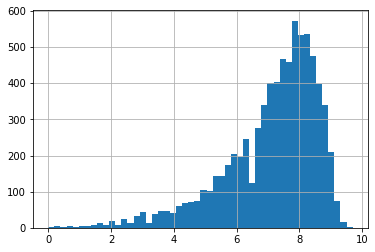

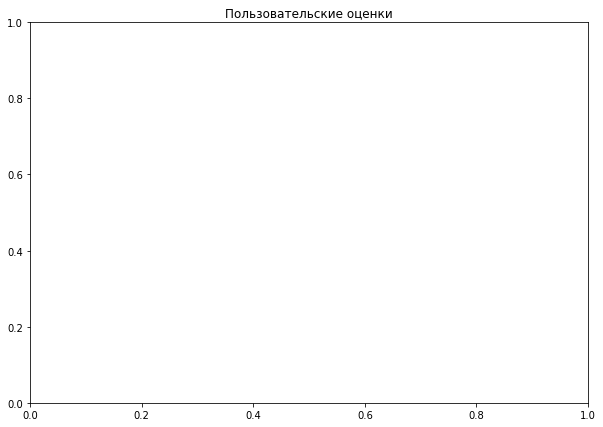

In [18]:
data['user_score'].hist(bins=50)
plt.title('Пользовательские оценки')
plt.show()

Распределение по форме похоже на нормальное, имеет отрицательную скошенность - в распределении много меньших относительно среднего по своей величине значений. Пользователи более склонны ставить невысокие оценки играм.

Значения оценки критиков и оценки пользователей переводить в int не имеет смысла, так как в столбцах critic_score и user_score присутствуют пропущенные значения.

Проверим, для каких игр пропущены значения года выпуска:

In [19]:
data.loc[data['year_of_release'].isna(), 'name']

183                        Madden NFL 2004
377                       FIFA Soccer 2004
456             LEGO Batman: The Videogame
475             wwe Smackdown vs. Raw 2006
609                         Space Invaders
                       ...                
16373    PDC World Championship Darts 2008
16405                        Freaky Flyers
16448                            Inversion
16458          Hakuouki: Shinsengumi Kitan
16522                         Virtua Quest
Name: name, Length: 269, dtype: object

Кажется, что для части игр можно заполнить пропуски в годе выхода, извлекая из названия год, однако при проверке таких игр выяснилось, что год, написанный в названии, не всегда совпадает с годом выпуска игр (например, согласно поисковым результатам, FIFA Soccer 2004 была выпущена в 2003 году).

Можно попросить коллег, чтобы они выгрузили и передали нам данные по дате выхода игр - тогда можно будет объединить таблицы по названию игры и заполнить пропуски. Но сейчас такой возможности нет.

В связи с вышесказанным, пропуски в годах выпуска игр оставим незаполненными.

Пропущенные значения жанров, оценок критиков и пользователей, рейтинга мы также не можем заполнить - не с чем сопоставить данные, чтобы определить подходящие значения для пропусков, а заполнения медианой или средним сильно исказит результаты анализа. Пропуски в названии игр также заполнить невозможно - мы не знаем, что это были за игры.

Name               0.000120
Year_of_Release    0.016093
Genre              0.000120
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786

На этапе изучения данных мы установили, что доля пропусков:
- в названии - 0,012%
- жанра - 0,012%
- года выпуска - 1,6%
- оценок критиков - 51,3%
- оценок пользователей - 40%
- рейтинга - 40,5%

Таким образом, относительно безболезненно можно избавиться от данных с пропусками названия, жанра и года выпуска игры.

In [20]:
print('Количество пропусков названия игр:', data['name'].isna().sum())
print('Количество пропусков жанра игр:', data['genre'].isna().sum())
print('Количество пропусков года выпуска игр:', data['year_of_release'].isna().sum())

Количество пропусков названия игр: 2
Количество пропусков жанра игр: 2
Количество пропусков года выпуска игр: 269


In [21]:
data.loc[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1780,530,0,80,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0,0,30,0,NaN,NaN,NaN


Удалим данные с пропусками названия игры, жанра и года выпуска. Их мало и заполнить пропуски не представляется возможным.

In [22]:
print('Количество строк, подлежающих удалению -', len(data.query('name.isna() or genre.isna() or year_of_release.isna()')))
print('Это {:.2%} от общего количества строк'.format(271 / 16715))

Количество строк, подлежающих удалению - 271
Это 1.62% от общего количества строк


In [23]:
data = data.dropna(subset=['name', 'genre', 'year_of_release']) #удаление строк с пропусками в названии, жанре, годе выпуска

Преобразуем год выпуска в тип int (год не может быть дробным, кроме того, float замедляет обработку данных) - в данном проекте нам доступны только года и нам не важен месяц или день недели выхода игры. Поэтому предпочтем числовой тип данных типу данных datetime.

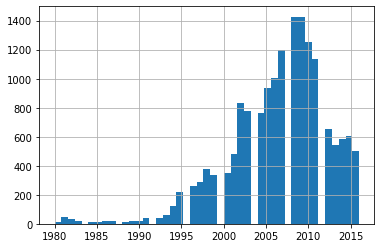

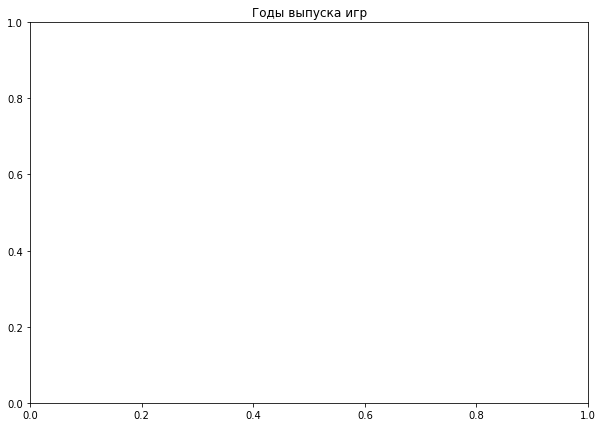

In [24]:
plt.figure(figsize=(10,7))
data['year_of_release'].hist(bins=45)
plt.title('Годы выпуска игр')
plt.show()

Форма распределения значений года выпуска игры похожа на форму нормального распределения.

In [25]:
data['year_of_release'].describe() #проверяем, что самый ранний и самый поздний год - не аномальные значения

count    16444.000000
mean      2006.486256
std          5.875525
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

In [26]:
data['year_of_release'] = data['year_of_release'].astype('int') #преобразуем в тип даныых int

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [27]:
data['sales_total'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [28]:
data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'sales_total']] #проверим значения в новом столбце

,na_sales,eu_sales,jp_sales,other_sales,sales_total
0,41360,28960,3770,8450,82540
1,29080,3580,6810,770,40240
2,15680,12760,3790,3290,35520
3,15610,10930,3280,2950,32770
4,11270,8890,10220,1000,31380
...,...,...,...,...,...
16710,0,0,10,0,10
16711,0,10,0,0,10
16712,0,0,10,0,10
16713,10,0,0,0,10


### Вывод

Года выпуска, продажи (предварительно преобразовали в тысячи, чтобы не потерять данные при округлении чисел) преобразованы в тип int. Для нас не важен месяц или день недели выпуска игры, поэтому для года выпуска выбран int, а не datetime. Данные типа int будут обрабатываться гораздо быстрее, чем float, а смысл данных и распределение не поменяются.


В пользовательских оценках были обработаны строковые значения tbd (оценка еще не определена), которые мы заменили на пропуски (не на ноль, так как ноль - это самая низкая оценка, а не отсутствие оценки), что позволило поменять тип данных столбца на числовой. После с помощью гистограммы оценено распределение данных в столбце - пользователи более склонны ставить невысокие оценки играм. Были удалены строки с пропусками названия, жанра и года выпуска игры - самые малочисленные в отношении доли пропусков.
me.

Также мы посчитали суммарные продажи во всех регионах и записали их в отдельный столбец.

Возможные причины появления пропусков данных:

- данные по случайности не были внесены
- данные были намеренно сокрыты
- значение отсутствует, поэтому не было внесено
- технический сбой
- удаление уже внесенных данных
- появление пропусков при слиянии таблиц (merge или join)

## Исследовательский анализ данных

Сколько игр выпускалось в разные годы? Важны ли данные за все периоды?

Для удобства оценки количества выпускаемых игр в разные года сгруппируем игры по году выпуска и для каждого года посчитаем количество игр. На основе этой группировки построим столбчатую диаграмму.

In [29]:
def make_plot(df, index, values, func, title, sort): # создадим функцию для упрощения вывода графиков
    if sort == False:
        df.pivot_table(index=index, values=values, aggfunc=func).plot(kind='bar', figsize=(11, 7), grid=True)
        plt.title(title)
        plt.show()
    else:
        df.pivot_table(index=index, values=values, aggfunc=func).sort_values(by=values).plot(kind='bar', figsize=(11, 7), grid=True)
        plt.title(title)
        plt.show()

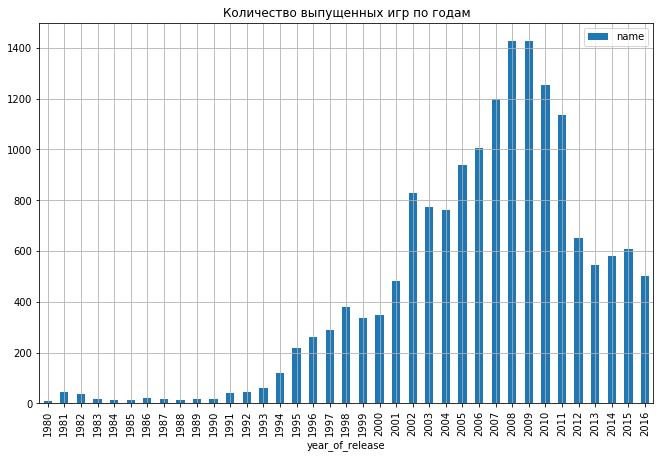

In [30]:
make_plot(data, 'year_of_release', 'name', 'count', 'Количество выпущенных игр по годам', False)

Из графика видно, что количество выпускаемых игр росло с 1980 года по 2008. С 2010 года количество ежегодно выпускаемых игр начало снижаться.

Пик количества выпускаемых игр пришёлся на 2008-2009гг. - в каждом из них было выпущено свыше 1400 игр.

Для нас важны данные не за все периоды - игровой индустрии все быстро меняется, появляются как новые игры, так и новые игровые приставки или видеокарты.

Попробуем определить актуальный период.

Выберем платформы с наибольшими суммарными продажами.

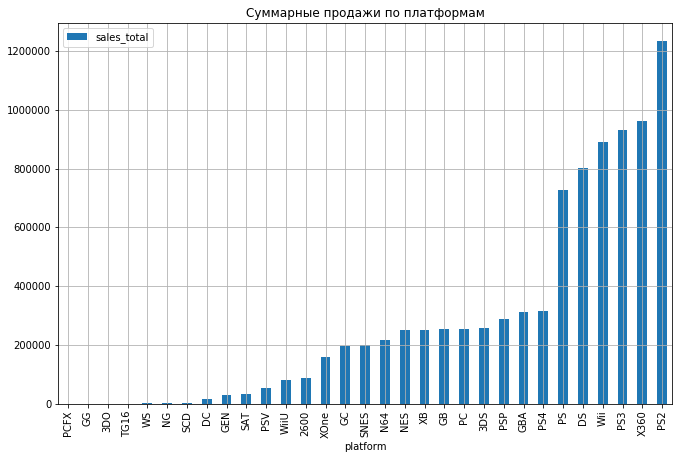

In [31]:
make_plot(data, 'platform', 'sales_total', 'sum', 'Суммарные продажи по платформам', True)

При визуальной оценке графика очевидно - "выиграли" 6 платформ:
- PS
- DS
- Wii
- PS3
- X360
- PS2

Общие продажи для каждой из этих платформ превышают 700 млн. Все остальные платформы не достигли даже половины такого объема продаж.

Построим распределение продаж для этих платформ по годам. 

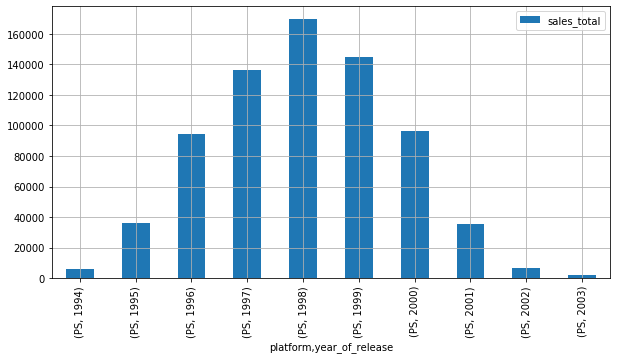

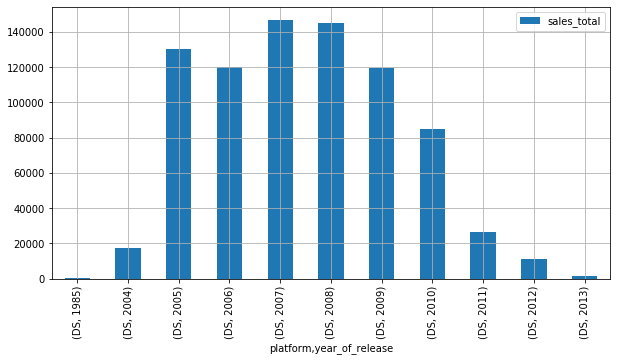

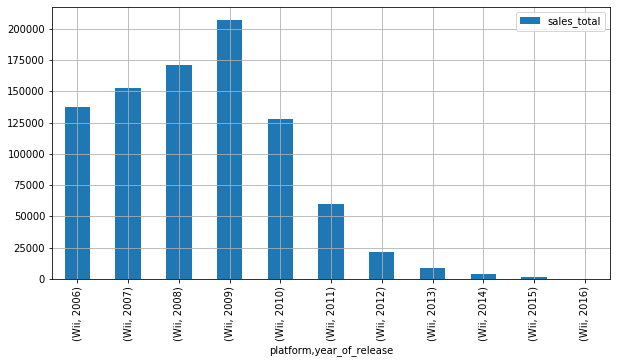

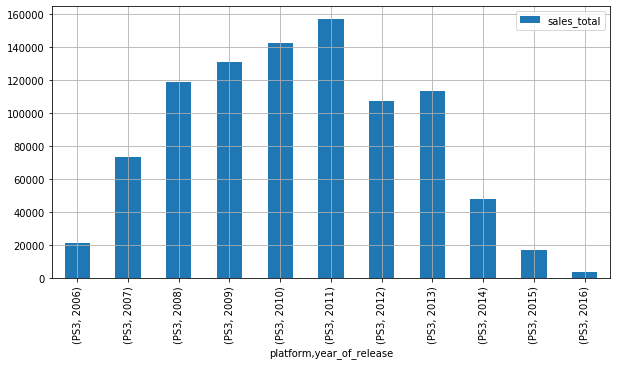

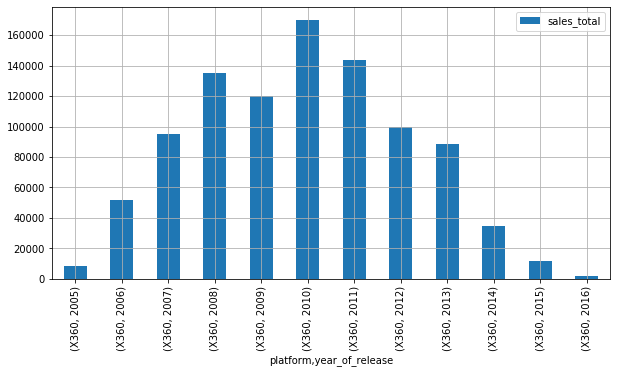

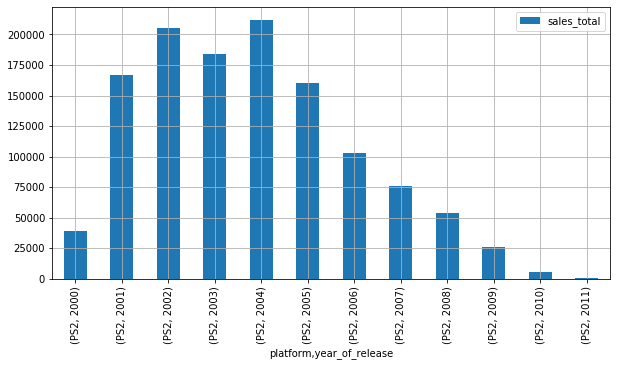

In [32]:
platforms_list = ['PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2']

for p in platforms_list:
    data.query('platform == @p').pivot_table(
        index=['platform', 'year_of_release'], values='sales_total', aggfunc='sum'
    ).plot(kind='bar', figsize=(10, 5), grid=True)

За какой характерный срок появляются новые и исчезают старые платформы?

Исходя из данных, представленных на графиках, популярные платформы появляются и исчезают в сроки 10-12 лет, чаще всего - 11 лет. В эти годы продажи постепенно растут, а потом падают.

Самые большие объемы продаж у платформ и рост продаж приходятся обычно на 6 лет их "жизни" - примем этот период за актуальный.

In [33]:
platform_years = []

for p in data['platform'].unique(): #подсчет среднего срока жизни платформы через разность минимального и максимального года
    platform_years.append(data.query('platform == @p')['year_of_release'].max() - data.query('platform == @p')['year_of_release'].min())

print(np.mean(platform_years)) #средний срок жизни платформы исходя из данных для каждой платформы датафрейма

7.612903225806452


Проанализируем график продаж различных платформ за последние 6 лет:

In [34]:
actual_platforms = data[['name', 'platform']].merge(
    data.query('year_of_release >= 2011')[['name', 'year_of_release']], on='name', how='inner')
#используем внутреннее объединение таблиц с условием года 2011 и позже, чтобы вычленить актуальные приставки

In [35]:
actual_platforms = actual_platforms['platform'].unique() #запишем в переменную уникальные значения актуальных приставок

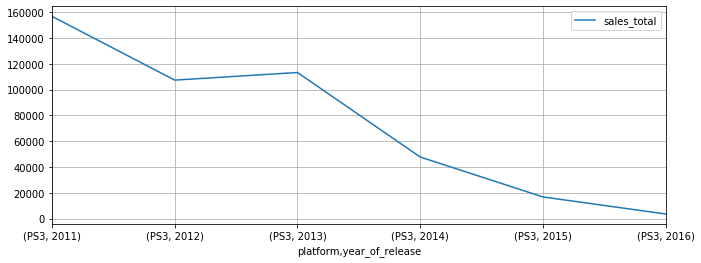

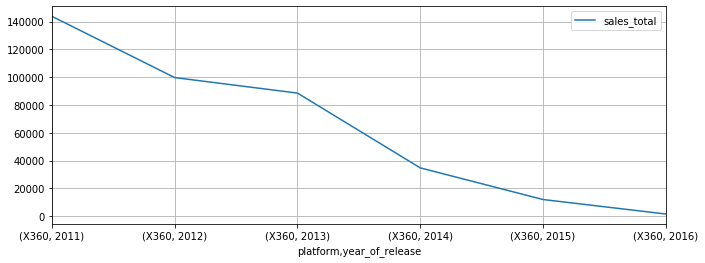

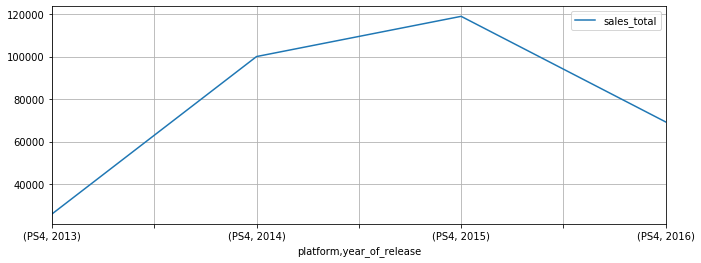

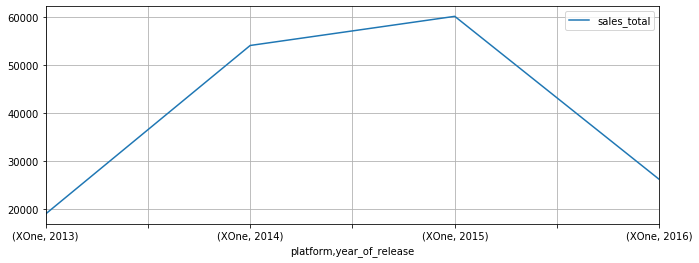

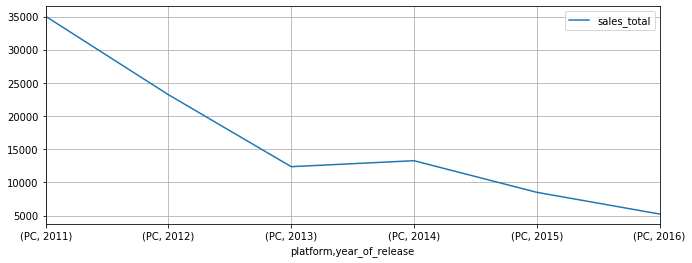

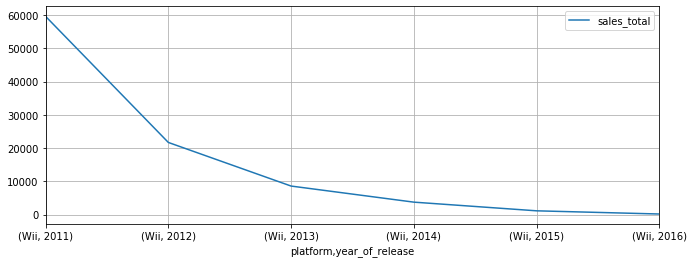

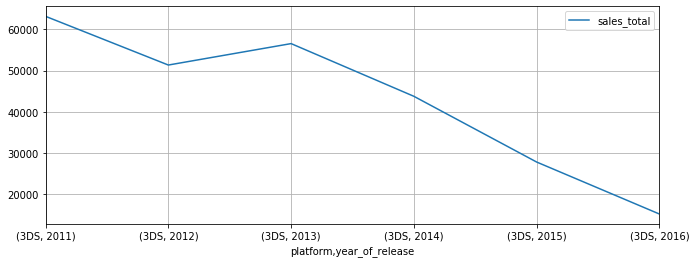

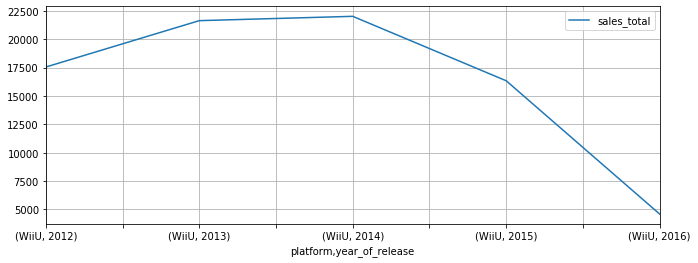

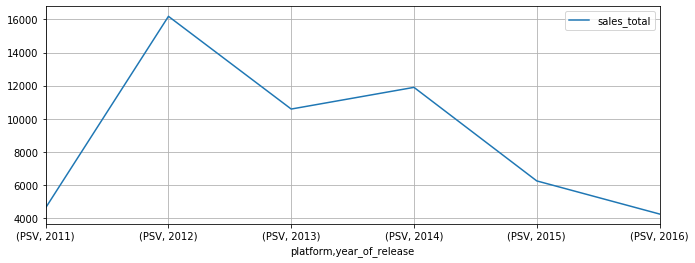

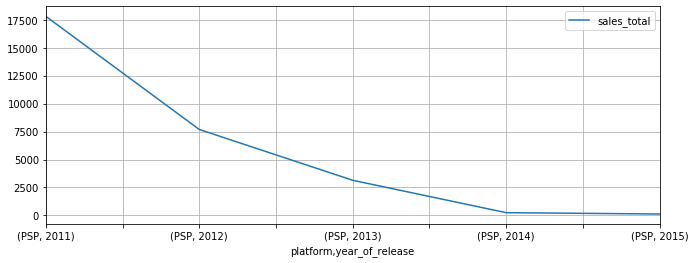

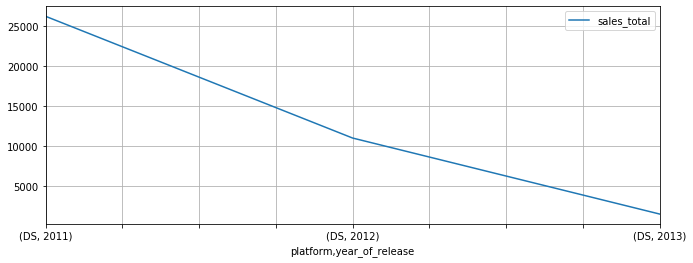

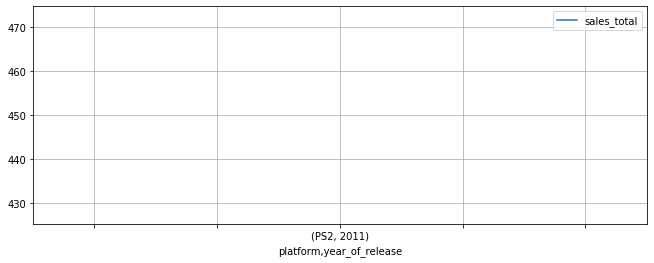

In [36]:
for p in actual_platforms:
    actual = data.query('(platform == @p) & (year_of_release >= 2011)').pivot_table(
        index=['platform', 'year_of_release'], values='sales_total', aggfunc='sum')
    if actual.empty:
        continue
    else:
        actual.plot(figsize=(11, 4), grid=True)

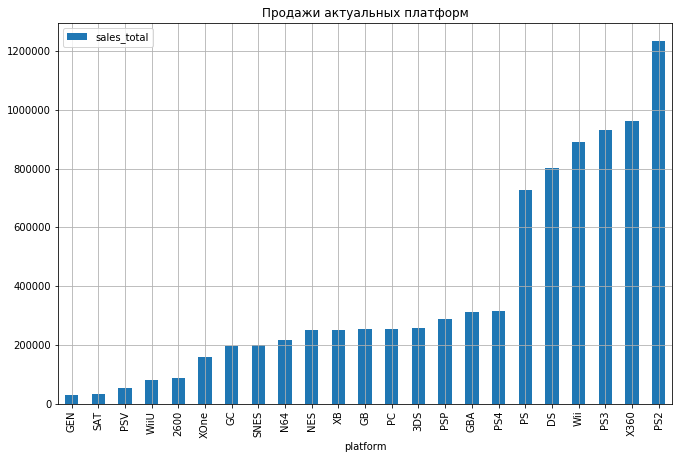

In [37]:
data.loc[data['platform'].isin(actual_platforms)].pivot_table(
    index='platform', values='sales_total', aggfunc='sum'
).sort_values(by='sales_total').plot(kind='bar', figsize=(11, 7), grid=True)
plt.title('Продажи актуальных платформ')
plt.show()

Топ актуальных платформ по продажам - PS2, Xbox 360, PS3, Wii, DS, PS. Топ не изменился. Видимо, основные объемы продаж были именно в актуальный период.

Какие платформы лидируют по продажам, растут или падают?

В течение последних шести лет по продажам лидировали WiiU, X360 и PS3, причем пиковые продажи X360 составили около 175 млн., PS3 - чуть менее 160 млн., а для WiiU - 225 млн. Более "молодые" платформы XOne и PS4, которые появились в 2013 году, также имели хорошие продажи, для них 2015 год был самым прибыльным - пиковые значения продаж PS4 120 млн., XOne - 60 млн. Пик 3DS и Wii - 60 млн. в 2011 году., PSP - около 55 млн. в 2006 году.

За последние 6 лет высокие объемы продаж также были для PC (пиковое значение в 2011 году - 35 млн.).

Однако нас больше интересуют не общие объемы продаж за весь период, а динамика продаж - мы должны выбрать платформы, которые останутся актуальны в 2017 году.

Продажи Wii, X360 и PS3 в течение нескольких последних лет имели тенденцию к снижению и в 2016 году их продажи упали практически до нуля.

Продажи PSP прекратились в 2015 году, DS - в 2013 году, PS2 - в 2011 году.

Однозначно, что наиболее перспективными являются две новые платформы, вышедшие в 2013 году - PS4 и XOne, для первой продажи в 2016 году превышают 60 млн., для второй - 25 млн. Это лучшие показатели продаж для 2016 года.

3DS имела около 15 млн. продаж в 2016 году, PC и WiiU около 5 млн., при этом у 3DS и WiiU, судя по графикам, есть явные тенденции к падению продаж.

Таким образом, наиболее перспекивны PS4 и XOne - они не только имеют самые высокие продажи, но и были выпущены недавно - в 2013 году (что важно, учитывая срок "актуальности" платформ в 6 лет).

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

In [38]:
actual_data = data.query('year_of_release >= 2011')

(0, 2000)

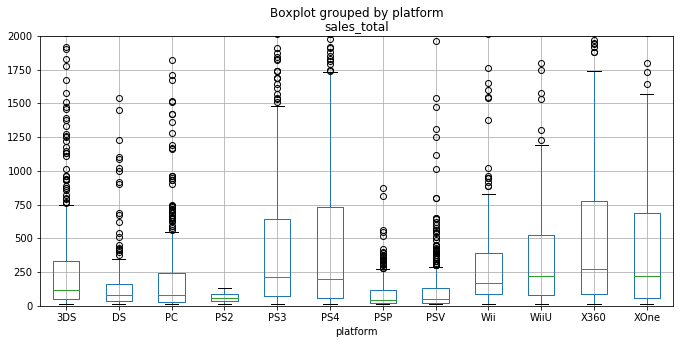

In [39]:
actual_data.boxplot('sales_total', by = 'platform', figsize=(11, 5))
plt.ylim([0, 2000])

Диаграмма размаха подтверждает выводы, сделанные по предыдущим графикам: лидеры по продажам, если судить по медиане и 75-ому процентилю - это PS3, PS4, X360 и XOne.

Почти все платформы имеют выбросы на высоких значениях - это выбивающиеся значения, которые выпдаают из общей картины продаж, возможно, выбросы получились в результате выпуска на рынок игр-бестселлеров (бестселлеры выходят нечасто).

Все демонстрируют положительную скошенность - значит, среднее таких данных больше, чем медиана.  

Интересно, что у PS2 совсем малый разброс - продаж за актуальный период было очень мало.

Стоит отметить, что такой график не отражает динамику продаж, поэтому выбирать перспективные платформы исходя из представленных на диаграмме размаха данных не стоит. Кроме того, представленные диаграммы размаха говорят о том, что в данных много выбивающихся из общей картины значений, от которых следует избавляться.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

В качестве популярной платформы выберем ту, для которой будет больше строк, где она встречается, при этом платформа должна быть актуальной.

In [40]:
actual_data.pivot_table(index='platform', values='name', aggfunc='count').sort_values(by='name', ascending=False).head(5)

,name
platform,
PS3,708
3DS,512
X360,498
PSV,429
PS4,392


Выберем для проверки связи отзывов и продаж платформу PS3 - она актуальна и для PS3 есть много данных.

In [41]:
stat_multi = actual_data.query('platform == "PS3"')[['sales_total', 'critic_score', 'user_score']]
display(stat_multi.corr())

,sales_total,critic_score,user_score
sales_total,1.000000,0.380111,0.014089
critic_score,0.380111,1.000000,0.563315
user_score,0.014089,0.563315,1.000000


Диаграмма рассеяния


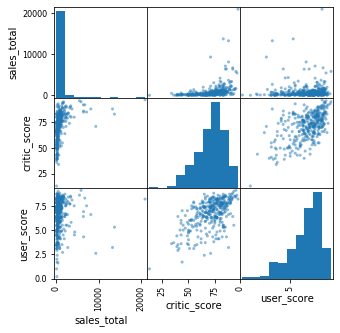

In [42]:
pd.plotting.scatter_matrix(stat_multi, figsize=(5, 5))
print('Диаграмма рассеяния')

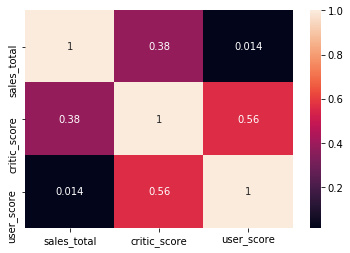

In [43]:
sns.heatmap(stat_multi.corr(), annot=True)

Существует положительная корреляционная связь средней силы между баллами отзывов критиков и продажами.

Положительная корреляционная связь слабой силы - между баллами отзывов пользователей и продажами.

Кроме того, баллы отзывов критиков и обычных пользователей также имеют связь - положительная корреляционная связь средней силы.

Таким образом, можно сделать вывод, что есть связь между отзывами и объемами продаж - чем выше баллы в отзывах, тем больше продаж, причем баллы критиков влияют на продажи сильнее, чем баллы обычных пользователей.

Соотнесем выводы о связи отзывов и продаж с продажами на других платформах.

PS3


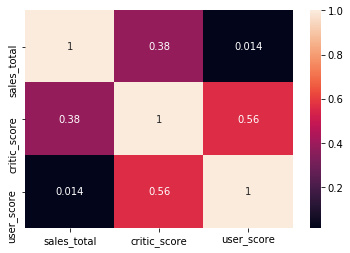


*********************************************
X360


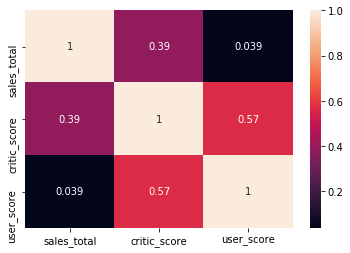


*********************************************
PS4


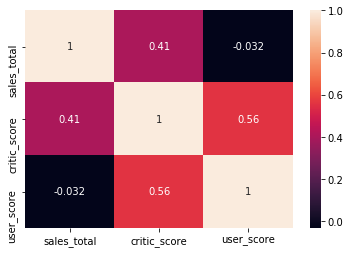


*********************************************
3DS


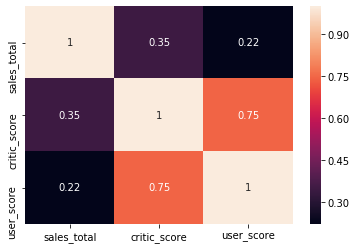


*********************************************
Wii


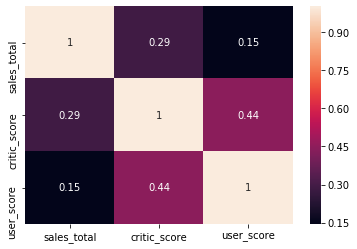


*********************************************
DS


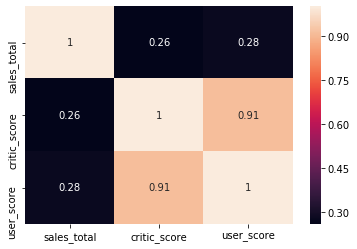


*********************************************
XOne


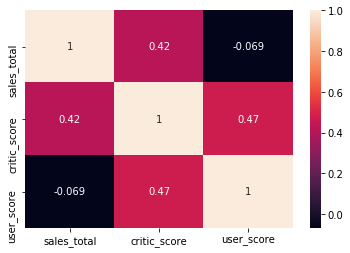


*********************************************
WiiU


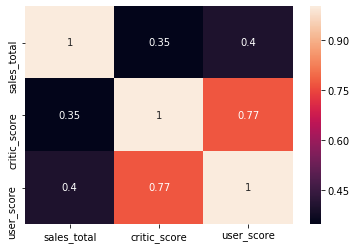


*********************************************
PC


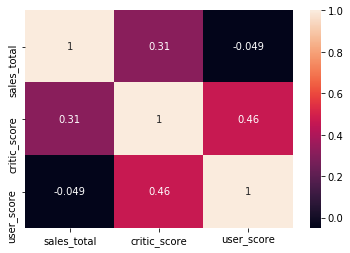


*********************************************
PSV


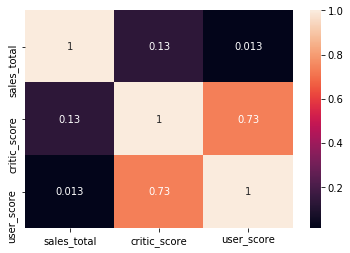


*********************************************
PSP


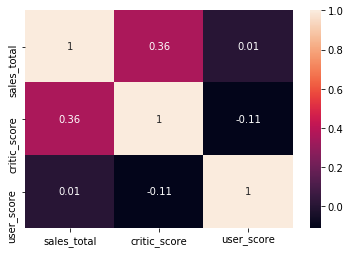


*********************************************
PS2


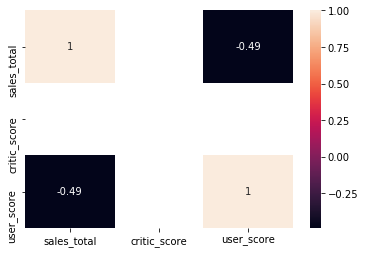


*********************************************


In [44]:
platforms = actual_data['platform'].unique()

for p in platforms: #подсчет коэффициентов корреляции для каждой из платформ
    print(p)
    sns.heatmap((actual_data.query('platform == @p')[['sales_total', 'critic_score', 'user_score']].corr()), annot=True)
    plt.show()
    print()
    print('***' * 15)

На популярных платформах со связями между продажами и отзывами критиков дело обстоит примерно так же, PS4, XOne, X360 имеют положительную корреляционную связь средней силы, коэффициент корреляции Пирсона для всех них примерно равен 0.4. 

На менее популярных платформах корреляционная связь между рейтингов отзывов критиков и продажами меньше - в пределах 0.35.

При этом связь между пользовательскими отзывами и продажами более вариативна, обычно отсутствует или слабой силы, и слабее связи с отзывами критиков и продажами. Но есть исключение - для WiiU сила связи между отзывами пользователей и продажами средняя и при этом больше, чем сила связи между отзывами критиков и продажами.

Посмотрим на общее распределение игр по жанрам. 

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [45]:
popular_genres = actual_data.pivot_table(index='genre', values='sales_total', aggfunc='sum')

In [46]:
popular_genres.sort_values(by='sales_total', ascending=False)

,sales_total
genre,
Action,557798
Shooter,402910
Role-Playing,245630
Sports,237150
Misc,139419
Platform,88680
Racing,88309
Fighting,66900
Simulation,50259


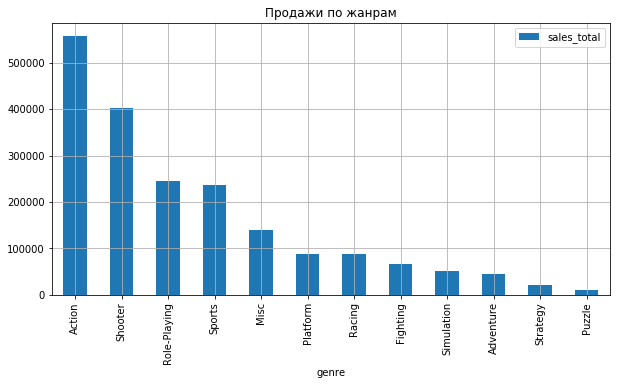

In [47]:
popular_genres.sort_values(by='sales_total', ascending=False).plot(kind='bar', grid=True, figsize=(10, 5))
plt.title('Продажи по жанрам')
plt.show()

In [48]:
popular_genres_mean = actual_data.pivot_table(index='genre', values='sales_total') #проверим средние значения

In [49]:
popular_genres_mean.sort_values(by='sales_total', ascending=False)

,sales_total
genre,
Shooter,1224.650456
Platform,726.885246
Sports,609.640103
Role-Playing,528.236559
Racing,490.605556
Action,439.557132
Fighting,420.754717
Misc,371.784000
Simulation,369.551471


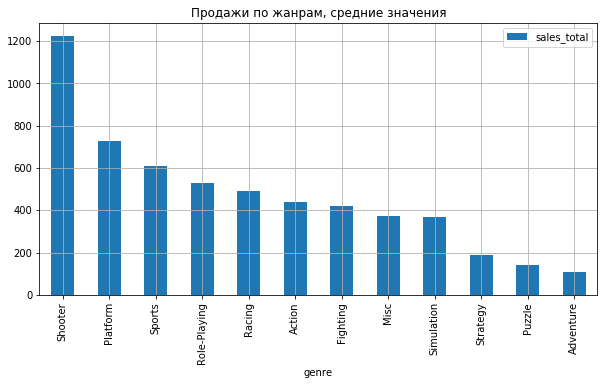

In [50]:
popular_genres_mean.sort_values(by='sales_total', ascending=False).plot(kind='bar', grid=True, figsize=(10, 5))
plt.title('Продажи по жанрам, средние значения')
plt.show()

Самый прибыльный жанр по сумме продаж - экшен. Он принес продаж более 500 млн. в актуальном периоде. Продажи 400 млн. у жанра шутер. Продажи 250 млн. у игр категории rpg и спортивных игр.

Однако при взгляде на средние продажи в расчете на одну игру определенного жанра, видно, что экшен сдает свои позиции. Самым прибыльным жанром оказался шутер с продажами более 1.2 млн. на одну игру данного жанра, экшен не достигает 0.5 млн. продаж на одну игру.

Шутер выделяется на графике как жанр с высокими продажами, продаж на одну игру жанра шутер почти в два раза больше, чем продаж игр жанра, который оказался на втором месте (платформенные игры).

Также на графике выделяются жанры с низкими продажами на одну игру жанра - стратегии, паззл, приключения.

### Вывод

В ходе исследовательского анализа данных было выявлено, что срок жизни платформ обычно составляет 10-12 лет, при этом период активных продаж для них составляет около 6 лет, что было принято за актуальный период.

Продажи для всех платформ за последние 6 лет имели тенденцию к падению. Лидируют по продажам в актуальном периоде платформы WiiU, Xbox 360 и PS3, а также более "молодые" платформы Xbox One и PS4, которые появились в 2013 году. 

Наиболее перспективными являются две новые платформы, вышедшие в 2013 году - PS4 и Xbox One, для первой продажи в 2016 году превышают 60 млн., для второй - 25 млн. Это лучшие показатели продаж для 2016 года. Данные подтверждены на диаграмме размаха ("ящик с усами").

На популярных платформах продажи и отзывы критиков имеют положительную корреляционную связь средней силы, коэффициент корреляции Пирсона для них примерно равен 0.4. На менее популярных платформах корреляционная связь между рейтингов отзывов критиков и продажами меньше - в пределах 0.35. Связь между пользовательскими отзывами и продажами обычно отсутствует или слабой силы. 

Самый прибыльный жанр - Shooter, он принес в среднем более 1.2 млн. продаж на одну игру.

##  Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5). 

- Самые популярные жанры (топ-5). 

- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Определим самые популярные платформы по регионам.

In [51]:
regions_pl = actual_data.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'])

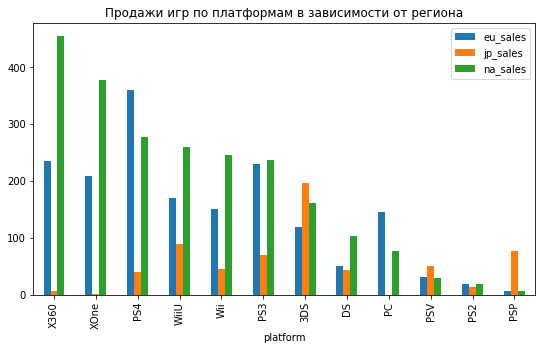

In [52]:
regions_pl.sort_values('na_sales', ascending=False).plot(kind='bar', figsize=(9, 5))
plt.title('Продажи игр по платформам в зависимости от региона')
plt.show()

In [53]:
print('топ-5 платформ NA')
regions_pl['na_sales'].sort_values(ascending=False).head(5)

топ-5 платформ NA


platform
X360    455.421687
XOne    377.004049
PS4     277.397959
WiiU    259.183673
Wii     246.492386
Name: na_sales, dtype: float64

In [54]:
print('топ-5 платформ EU')
regions_pl['eu_sales'].sort_values(ascending=False).head(5)

топ-5 платформ EU


platform
PS4     359.923469
X360    235.140562
PS3     230.365819
XOne    208.866397
WiiU    170.952381
Name: eu_sales, dtype: float64

In [55]:
print('топ-5 платформ JP')
regions_pl['jp_sales'].sort_values(ascending=False).head(5)

топ-5 платформ JP


platform
3DS     196.523438
WiiU     88.503401
PSP      77.051282
PS3      69.759887
PSV      50.909091
Name: jp_sales, dtype: float64

Самые популярные платформы во всех регионах - X360, XOne, PS4.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba1fabab90>],
      dtype=object)

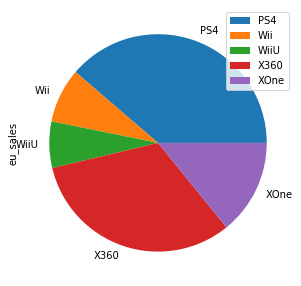

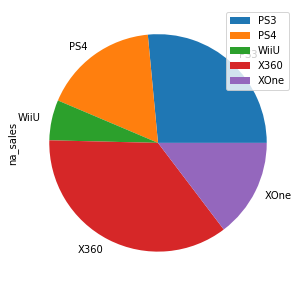

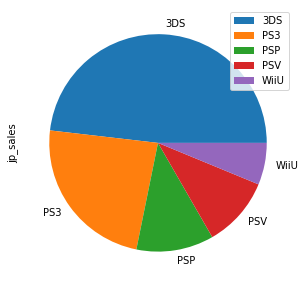

In [56]:
popular_platforms_eu = ['X360', 'XOne', 'PS4', 'WiiU', 'Wii']
popular_platforms_na = ['PS4', 'X360', 'PS3', 'XOne', 'WiiU']
popular_platforms_jp = ['3DS', 'WiiU', 'PSP', 'PS3', 'PSV']

actual_data.query('platform in @popular_platforms_eu').pivot_table(
    index='platform', values='eu_sales', aggfunc='sum'
).plot(kind='pie', subplots=True, figsize=(14, 5))

actual_data.query('platform in @popular_platforms_na').pivot_table(
    index='platform', values='na_sales', aggfunc='sum'
).plot(kind='pie', subplots=True, figsize=(14, 5))

actual_data.query('platform in @popular_platforms_jp').pivot_table(
    index='platform', values='jp_sales', aggfunc='sum'
).plot(kind='pie', subplots=True, figsize=(14, 5))

В Европе большую долю рынка занимают PS4 и Xbox 360, причем между собой их доли примерно равны.

В Северной Америке около трети рынка занимает Xbox350, чуть четверти - PS3, примерно по 15% доли рынка занимают PS4 и Xbox One.

В Японии почти половину рынка занимает платформа 3DS, около четверти - PS3.

Определим самые популярные жанры по регионам.

In [57]:
regions_g = actual_data.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'])

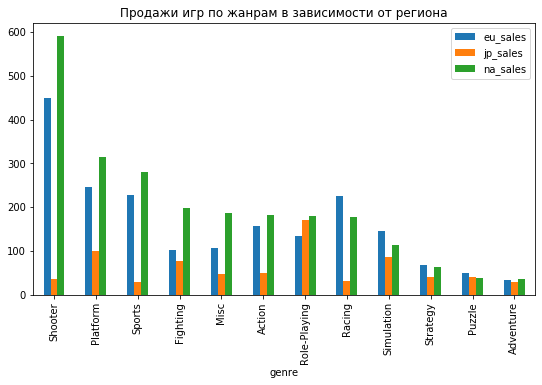

In [58]:
regions_g.sort_values('na_sales', ascending=False).plot(kind='bar', figsize=(9, 5))
plt.title('Продажи игр по жанрам в зависимости от региона')
plt.show()

In [59]:
print('топ-5 жанров NA')
regions_g['na_sales'].sort_values(ascending=False).head(5)

топ-5 жанров NA


genre
Shooter     590.972644
Platform    313.770492
Sports      279.434447
Fighting    198.930818
Misc        185.837333
Name: na_sales, dtype: float64

In [60]:
print('топ-5 жанров EU')
regions_g['eu_sales'].sort_values(ascending=False).head(5)

топ-5 жанров EU


genre
Shooter     449.908815
Platform    246.475410
Sports      227.455013
Racing      225.438889
Action      156.910165
Name: eu_sales, dtype: float64

In [61]:
print('топ-5 жанров JP')
regions_g['jp_sales'].sort_values(ascending=False).head(5)

топ-5 жанров JP


genre
Role-Playing    171.763441
Platform         99.426230
Simulation       85.588235
Fighting         77.861635
Action           50.133964
Name: jp_sales, dtype: float64

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [62]:
actual_data['rating'].unique() #необходимо сделать из категориальных данных числа, чтобы можно было посчитать корреляцию

array(['M', nan, 'E', 'E10+', 'T', 'EC', 'RP'], dtype=object)

Так как рейтинг возрастной, то мы легко можем заменить обозначения ESRB на соотвествующий возраст.

In [63]:
def to_age(esrb):
    if esrb == 'EC': #«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет
        return 3
    elif esrb == 'E': #«E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет
        return 6
    elif esrb == 'E10+': #«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
        return 10
    elif esrb == 'T': #«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет
        return 13
    elif esrb == 'M': #«M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет
        return 17
#«RP» («Rating Pending») — «Рейтинг ожидается» - пусть значения с таким рейтингом остаются пустыми, чтобы не искажать данные 

In [64]:
actual_data['rating_age'] = actual_data['rating'].apply(to_age)

In [65]:
actual_data['rating_age'].unique() #проверяем уникальные значения столбца

array([17., nan,  6., 10., 13.,  3.])

In [66]:
stat_region_rating = actual_data[['rating_age', 'na_sales', 'eu_sales', 'jp_sales']]
display(stat_region_rating.corr())

,rating_age,na_sales,eu_sales,jp_sales
rating_age,1.000000,0.103786,0.099997,-0.021192
na_sales,0.103786,1.000000,0.779712,0.273735
eu_sales,0.099997,0.779712,1.000000,0.278535
jp_sales,-0.021192,0.273735,0.278535,1.000000


Диаграмма рассеяния


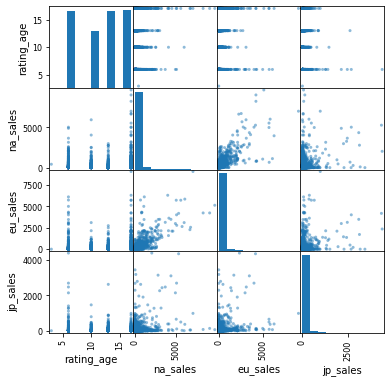

In [67]:
pd.plotting.scatter_matrix(stat_region_rating, figsize=(6, 6))
print('Диаграмма рассеяния')

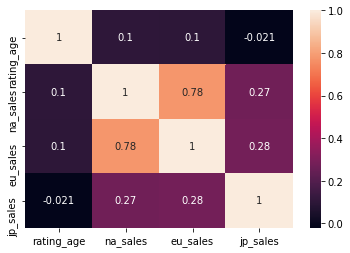

In [68]:
sns.heatmap(stat_region_rating.corr(), annot=True)

Связь между рейтингом ESRB и продажами в регионах разная:
- слабая положительная корреляционная связь между рейтингом и продажами в Северной Америке и Европе (чем выше возрастной рейтинг, тем больше продажи) - коэффициент Пирсона около 0.1
- в Японии корреляция между возрастным рейтингом и продажами не выявлена.

### Вывод

Топ-5 платформ в Европе - X360, XOne, PS4, WiiU, Wii.
Топ-5 платформ в Северной Америке - PS4, X360, PS3, XOne, WiiU.
Топ-5 платформ в Японии - 3DS, WiiU, PSP, PS3, PSV.

В Европе большую долю рынка занимают PS4 и Xbox 360, причем между собой их доли примерно равны, в Северной Америке около трети рынка занимает Xbox350, чуть четверти - PS3, примерно по 15% доли рынка занимают PS4 и Xbox One, в Японии почти половину рынка занимает платформа 3DS, около четверти - PS3.

Таким образом, для самых актуальных и новых платформы PS4 и Xbox One, самые перспективные рынки - это Европа и Северная Америка.

Возрастной рейтинг игры влияет на продажи в Европе и Северной Америке (слабая положительная корреляционная связь) - чем выше возрастной рейтинг (чем на более взрослую аудиторию рассчитана игра), тем выше продажи. Связь между возрастным рейтингом и продажами в Японии не выявлена.

## Проверка гипотез

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [69]:
x_one = actual_data.query('platform == "XOne"')['user_score'].dropna() # сделаем срезы и удалим пропуски
pc = actual_data.query('platform == "PC"')['user_score'].dropna()

In [70]:
print('Средний пользовательский рейтинг XOne, дисперсия и стандартное отклонение: {:.2f}, {:.2f}, {:.2f}'.format(
    x_one.mean(), np.var(x_one, ddof=1), np.std(x_one, ddof=1))
     )
print('Средний пользовательский рейтинг PC, дисперсия и стандартное отклонение: {:.2f}, {:.2f}, {:.2f}'.format(
    pc.mean(), np.var(pc, ddof=1), np.std(pc, ddof=1))
     )

Средний пользовательский рейтинг XOne, дисперсия и стандартное отклонение: 6.52, 1.91, 1.38
Средний пользовательский рейтинг PC, дисперсия и стандартное отклонение: 6.45, 2.60, 1.61


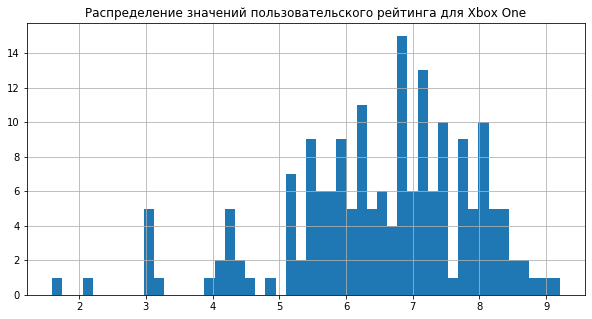

In [71]:
x_one.hist(bins=50, figsize=(10, 5))
plt.title('Распределение значений пользовательского рейтинга для Xbox One')
plt.show()

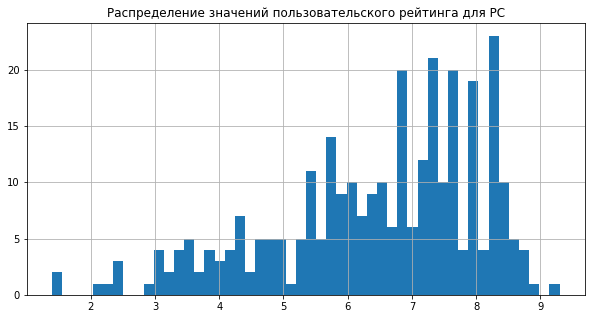

In [72]:
pc.hist(bins=50, figsize=(10, 5))
plt.title('Распределение значений пользовательского рейтинга для PC')
plt.show()

Большой разброс значений виден не только при расчете дисперсии и стандартного отклонения, но и на графиках. Выберем высокий уровень статистической значимости, чтобы быть уверенными в результате.

***H₀: средние пользовательские рейтинги платформ Xbox One и PC равны.***

***H₁: средние пользовательские рейтинги платформ Xbox One и PC не равны.***

In [73]:
def hypothesis_check(sample1, sample2, alpha): #создадим функцию для расчета статистических тестов
    results = st.ttest_ind(sample1, sample2) 
    
    print('p-значение:', results.pvalue)
    
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [74]:
alpha = 0.01 #выбран высокий уровень значимости, чтобы иметь уверенность в результате

In [75]:
hypothesis_check(x_one, pc, alpha)

p-значение: 0.6267602271422398
Не получилось отвергнуть нулевую гипотезу


*Полученное значение p-value говорит о том, что такое же или большее различие в значениях пользовательского рейтинга между платформами Xbox One и PC получить случайно можно с вероятностью 62,7%. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними значениями выручки.*

**Нулевая гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC не может быть отвергнута.**

~~~

In [76]:
action = actual_data.query('genre == "Action"')['user_score'].dropna() # сделаем срезы и удалим пропуски
sports = actual_data.query('genre == "Sports"')['user_score'].dropna()

In [77]:
print('Средний пользовательский рейтинг жанра Action, дисперсия и стандартное отклонение: {:.2f}, {:.2f}, {:.2f}'.format(
    action.mean(), np.var(action, ddof=1), np.std(action, ddof=1)))
print('Средний пользовательский рейтинг жанра Sports, дисперсия и стандартное отклонение: {:.2f}, {:.2f}, {:.2f}'.format(
    sports.mean(), np.var(sports, ddof=1), np.std(sports, ddof=1)))

Средний пользовательский рейтинг жанра Action, дисперсия и стандартное отклонение: 6.78, 1.81, 1.35
Средний пользовательский рейтинг жанра Sports, дисперсия и стандартное отклонение: 5.65, 2.88, 1.70


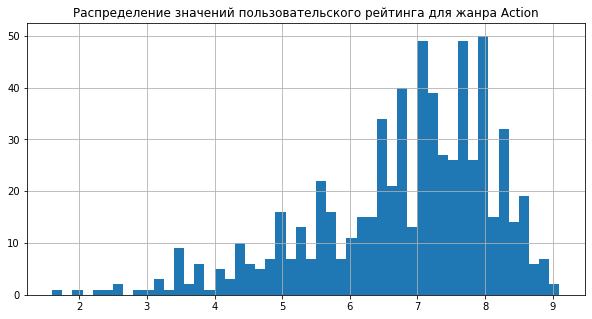

In [78]:
action.hist(bins=50, figsize=(10, 5))
plt.title('Распределение значений пользовательского рейтинга для жанра Action')
plt.show()

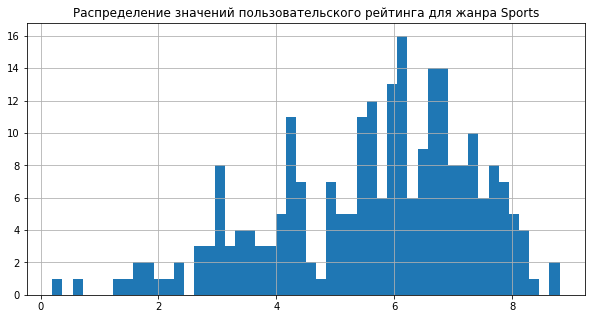

In [79]:
sports.hist(bins=50, figsize=(10, 5))
plt.title('Распределение значений пользовательского рейтинга для жанра Sports')
plt.show()

Снова наблюдаем большой разброс. Выберем высокий уровень значимости (уже записан в переменной alpha ранее).

***H₀: средние пользовательские рейтинги жанров Action и Sports равны.***

***H₁: средние пользовательские рейтинги жанров Action и Sports не равны.***

In [80]:
hypothesis_check(action, sports, alpha)

p-значение: 5.1974550252152054e-24
Отвергаем нулевую гипотезу


*Полученное значение p-value говорит о том, что такое же или большее различие в значениях пользовательского рейтинга между жанрами Action и Sports получить случайно можно с крайне малой вероятностью. Таким образом, нельзя делать вывод о незначимом различии между средними значениями пользовательских рейтингов платформ.*

**Нулевая гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports отвергнута.**

### Вывод

Статистически значимых различий между пользовательскими рейтингами Xbox One и PC выявлено не было. Средние пользовательские рейтинги для этих платформ составляют около 6.5 баллов. При этом разброс значений для PC больше, судя по дисперсии и стандартному отклонению.

Средние пользовательские рейтинги жанра экшен оказались статистически значимо больше средних пользовательских рейтингов жанра спортивных игр - 6.78 баллов против 5.65.

Нулевые гипотезы были сформулированы исходя из того, что нулевая гипотеза всегда должна содержать знак равенства.

Использован t-критерий Стьюдента, так как нам нужна оценка статистической значимости разности двух выборочных средних, а имеем мы не слишком большие выборки с большим разбросом значений.

Использован подход гипотезы о равенстве средних двух генеральных совокупностей, метод ttest_ind из stats, так как мы проверяли две независимые выборки.

## Общий вывод

В ходе исследовательского анализа данных было выявлено, что срок жизни платформ обычно составляет 10-12 лет, при этом период активных продаж для них составляет около 6 лет. Продажи для всех платформ за последние 6 лет имели тенденцию к падению. 

Лидируют по продажам в актуальном периоде платформы WiiU, Xbox 360, PS3, Xbox One и PS4.

Наиболее перспективными являются новые платформы, вышедшие в 2013 году и одни из лидеров по продажам за последние 6 лет - PS4 и Xbox One.

На популярных платформах выявлена связь средней силы между рейтингом отзывов критиков и продажами игр. На менее популярных платформах эта связь немного слабее. Связь между пользовательским рейтингом и продажами обычно отсутствует или слабая.

Самый прибыльный жанр - Shooter, который принес более более 1.2 млн. продаж в актуальном периоде в расчете на одну игру жанра. 

Топ-5 платформ в Европе - X360, XOne, PS4, WiiU, Wii. Топ-5 платформ в Северной Америке - PS4, X360, PS3, XOne, WiiU. Топ-5 платформ в Японии - 3DS, WiiU, PSP, PS3, PSV.

В Европе большую долю рынка занимают PS4 и Xbox 360, в Северной Америке около трети рынка занимает Xbox350, чуть четверти - PS3, примерно по 15% доли рынка занимают PS4 и Xbox One, в Японии почти половину рынка занимает платформа 3DS, около четверти - PS3.

Это значит, что для выбранных потенциально прибыльных платформ PS4 и Xbox One, самые перспективные рынки - это Европа и Северная Америка.

Возрастной рейтинг игры влияет на продажи только в Европе и Северной Америке, такая связь для Японии не выявлена.

Статистически значимых различий между пользовательскими рейтингами Xbox One и PC выявлено не было. Средние пользовательские рейтинги для этих платформ составляют около 6.5 баллов. Таким образом, оценка утверждения "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - да, в целом они одинаковы.

Средние пользовательские рейтинги жанра экшен статистически значимо больше средних пользовательских рейтингов жанра спортивных игр - 6.78 баллов против 5.65. Значит, оценка утверждения "Средние пользовательские рейтинги жанров Action и Sports разные" - да, в целом они различаются.

Таким образом, успешная игра - это игра в жанре Shooter, выпускающаяся для платформ PS4 и Xbox One - эти платформы новые и в 2017 году точно будут продолжать быть популярными. Кроме того, они популярны у пользователей из Европы и Северной Америки. Желательно, чтобы возрастной рейтинг ESRB был большим, так как в Европе и Северной Америке, на рынки которых мы будем ориентироваться (так как наши перспективные платформы там наиболее распространены), предпочитают игры с более высокими возрастным рейтингами. На такую игру стоит сделать ставку и планировать для неё рекламные компании.

Делать ставку на игры для 3DS не стоит, несмотря на её популярность в Японии - в других регионах эта платформа непопулярна, кроме того, её продажи невелики и имеют тенденцию к дальнейшему снижению - фаза "жизни" платформы подходит к завершению. 